# Data Generation
Heston Model:
$$dS_{t}={\sqrt  {V _{t}}}S_{t}\,dW_{t}, \ S_{0}=s_{0}>0$$
$$dV _{t}=a (b -V _{t})\,dt+c {\sqrt  {V _{t}}}\,dZ_{t}, \ V_{0}=v_{0}>0$$
Model Parameters: 
$$\theta = (a,b,c,\rho)$$

SABR Model:
$$dS_{t}=V_{t}S_{t}^{\beta }\,dW_{t}, \ S_{0}=s_{0}>0,  \ \beta \in [0,1]$$
$$dV_{t}=\alpha V_{t}^{}\,dZ_{t}, \ V_{0}=v_{0}>0$$
Model Parameters:
$$\theta = (\alpha,\beta,\rho)$$

Approch: Simulate market for different parameters using Euler-Maruyama

Goal: function with input: $$\theta$$ and output: $$P(\{(strikes,maturities)\})$$

## Brownian Motion

In [1]:
from math import sqrt
from scipy.stats import norm
import numpy as np

In [2]:
def brownian_motion(n, T, dim, out=None):
    dt = T/n
    
    r = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))

    if out is None:
        out = np.zeros((dim,n+1))
        
    np.cumsum(r, axis=-1, out=out)
 
    return out

In [3]:
n=1000
T=2
dim=8

bm = brownian_motion(n,T,dim)
bm.shape

(8, 1001)

In [4]:
import matplotlib.pyplot as plt

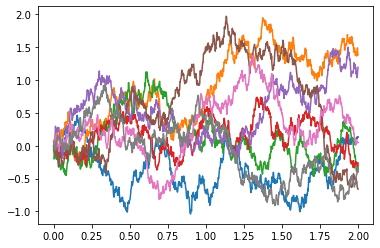

In [5]:
for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), bm[k,:])    


## Correlated Brownian Motion

In [6]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

In [7]:
n=1000
T=2
dim=2
rho=-1

W,Z = corr_brownian_motion(n,T,dim,rho)
W.shape

(2, 1001)

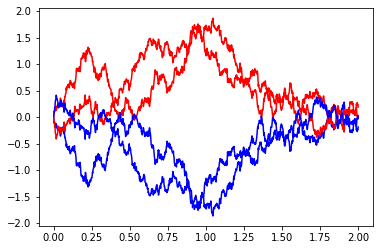

In [8]:
for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), W[k,:], "r") 
    plt.plot(np.linspace(0,T,n+1), Z[k,:], "b") 

## Euler Maruyama and Milstein

For $${\mathrm  {d}}X_{t}=\mu(X_{t})\,{\mathrm  {d}}t+\sigma(X_{t})\,{\mathrm  {d}}W_{t}$$
the Euler Maruyama method reads: $$\,Y_{{n+1}}=Y_{n}+\mu(Y_{n})\,\Delta t+\sigma(Y_{n})\,(W_{{\tau _{{n+1}}}}-W_{{\tau _{n}}})\, \ 
with \ Y_{{0}} = X_{{0}}$$

In [9]:
from scipy.stats import norm
import numpy as np

In [10]:
def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

The Milstein method reads: $$\,Y_{{n+1}}=Y_{n}+\mu(Y_{n})\,\Delta t+\sigma(Y_{n})\,(W_{{\tau _{{n+1}}}}-W_{{\tau _{n}}}) +{\frac {1}{2}}\sigma(Y_{n})\sigma'(Y_{n})\left((W_{{\tau _{{n+1}}}}-W_{{\tau _{n}}})^{2}-\Delta t\right)\, \ 
with \ Y_{{0}} = X_{{0}}$$


In [11]:
def milstein(mu,sigma,sigma_derivative,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + mu(Y[l,i],l,i)*dt + np.multiply(sigma(Y[l,i],l,i)*sqrt_dt,(W[l,i+1]-W[l,i]))+0.5*sigma(Y[l,i],l,i)*sigma_derivative(Y[l,i],l,i)*(np.power((W[l,i+1]-W[l,i]),2)-dt)
    
    return Y

## Heston Model

In [12]:
#work in progress
def heston(a,b,c,T,W,Z,V0,S0):
    #assert(2*a*b > c*c) 
    
    def mu2(V,i,k):
        return np.multiply(a,(b-V))
    
    def sigma2(V,i,k):
        return np.multiply(c,np.sqrt(np.maximum(0.0,V)))
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(np.sqrt(np.maximum(0.0,V[i,k])),S)
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V
    

### Test

1.047328963062841
0.2597201670827163
Call option price:  0.23750503634702724


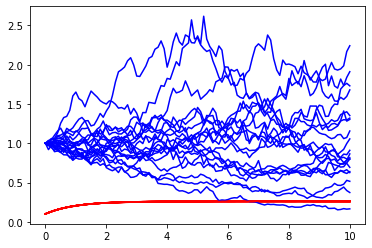

In [13]:
#(1, 0.16, 0.16, 1, 2, 0, -0.8, 10, 2)
#(s0, v0, vbar, a, vvol, r, rho, t, k)
a=1
b=0.26 #long term vol
c=0.01
T=10
n=100
dim=20
rho=-0.8
Strike = 1

W,Z = corr_brownian_motion(n,T,dim,rho)
V0 = 0.1
S0 = 1

S,V = heston(a,b,c,T,W,Z,V0,S0)
S_T = S[:,n]
V_T = V[:,n]
S_T_mean = np.mean(S_T, axis=0)
V_T_mean = np.mean(V_T, axis=0)

C = np.mean(np.maximum(S_T-Strike,np.zeros(dim)))

print(S_T_mean)
print(V_T_mean)
print("Call option price: ", C)

for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), V[k,:],"r") 
    plt.plot(np.linspace(0,T,n+1), S[k,:], "b") 

In [14]:
def heston_milstein(a,b,c,T,W,Z,V0,S0):
    assert(2*a*b > c*c)
    
    def mu2(V,i,k):
        return np.multiply(a,(b-V))
    
    def sigma2(V,i,k):
        return np.multiply(c,np.sqrt(np.maximum(0.0,V))) #avoid taking square root of something negative
    
    def sigma_dev2(V,i,k):
        return c/2/np.sqrt(np.maximum(0.001,V)) #avoid dividing by to small numbers or even zero
    
    V = milstein(mu2,sigma2,sigma_dev2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.sqrt(np.maximum(0.0,V[i,k]))*S
    
    def sigma_dev1(S,i,k):
        return np.sqrt(np.maximum(0.0,V[i,k]))
    
    S = milstein(mu1,sigma1,sigma_dev1,T,S0,W)
    
    return S,V

### Test

0.8903312922280465
0.25671246210718685
Call option price:  0.16215379412045666


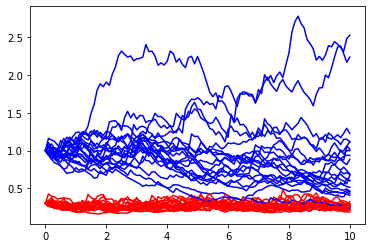

In [15]:
a=2
b=0.26 #long term vol
c=0.5
T=10
n=100
dim=20
rho=-0.8
Strike = 1

W,Z = corr_brownian_motion(n,T,dim,rho)
V0 = 0.3
S0 = 1

S,V = heston_milstein(a,b,c,T,W,Z,V0,S0)
S_T = S[:,n]
V_T = V[:,n]
S_T_mean = np.mean(S_T, axis=0)
V_T_mean = np.mean(V_T, axis=0)


print(S_T_mean)
print(V_T_mean)

C = np.mean(np.maximum(S_T-Strike,np.zeros(dim)))
print("Call option price: ", C)

for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), V[k,:],"r") 
    plt.plot(np.linspace(0,T,n+1), S[k,:], "b") 

## SABR Model

In [16]:
#work in progress

In [17]:
def sabr(alpha,beta,T,W,Z,V0,S0):
    assert(beta>0 and beta<1)

    def mu2(V,i,k):
        return 0.0
    
    def sigma2(V,i,k):
        return np.multiply(alpha,V)
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(V[i,k],np.power(np.maximum(0.0,S),beta))
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

### Test

0.9999358039806977
0.5000928546055011


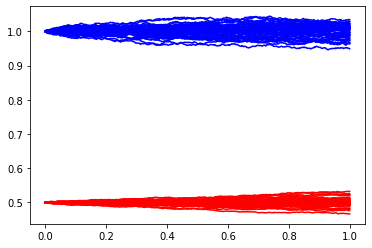

In [18]:
alpha=0.5
beta=0.5
T=1
n=500
dim=50
W=brownian_motion(n,T,dim)
Z=brownian_motion(n,T,dim)
V0 = 0.5
S0 = 1

S,V = sabr(alpha,beta,T,W,Z,V0,S0)
S_T = S[:,T]
V_T = V[:,T]
S_T_mean = np.mean(S_T, axis=0)
V_T_mean = np.mean(V_T, axis=0)


print(S_T_mean)
print(V_T_mean)

for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), V[k,:], "r") 
    plt.plot(np.linspace(0,T,n+1), S[k,:], "b") 

## Heston using closed form solution
Following the ideas of https://arxiv.org/pdf/1502.02963.pdf

In [19]:
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration

In [20]:
#helper functions for heston_closed
#NOT NEEDED ANY MORE

def aplha(w):
    return -0.5*w*(w+complex(0,1))

def beta(a,c,rho,w):
    return a - rho*c*w*complex(0,1)

def gamma(c):
    return c*c/2

def h(alpha,beta,gamma,a,c,rho,w):
    return (sqrt(beta(a,c,rho,w)*beta(a,c,rho,w)-4*alpha(w)*gamma(c)))

def rplus(aplha,beta,gamma,h,a,c,rho,w):
    return (beta(a,c,rho,w) + h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w))/c/c

def rminus(alpha,beta,gamma,h,a,c,rho,w):
    return (beta(a,c,rho,w) - h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w))/c/c

def g(rplus,rminus,alpha,beta,gamma,h,a,c,rho,w): 
    return rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha,beta,gamma,a,c,rho,w),a,c,rho,w)/rplus(alpha,beta(a,c,rho,w),gamma(c),h(alpha,beta,gamma,a,c,rho,w),a,c,rho,w)

def D(rminus,h,t,g,alpha,beta,gamma,a,c,rho,w):
    return rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w)*(1-cmath.exp(-h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w)*t))/(1-g(rplus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w)*cmath.exp(-hh(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w)*t))

def C(a,t,c,g,h,rplus,rminus,alpha,beta,gamma,rho,w):
    return a*(rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w)*t-2/c/c*cmath.log(1-g(rplus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w)*cmath.exp(-h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w)*t))/(1-cmath.exp(-h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w)*t)))

def char_func(w,C,D,V0,S0,r,a,b,c,t,g,alpha,beta,rminus,rplus,h):
    return cmath.exp(C(a,t,c,g(rplus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),rplus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),alpha(w),beta(a,c,rho,w),gamma(c),rho,w)*b + D(rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),t,g(rplus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),rminus(alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),alpha(w),beta(a,c,rho,w),gamma(c),h(alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w),a,c,rho,w),alpha(w),beta(a,c,rho,w),gamma(c),a,c,rho,w)*V0 + complex(0,1)*w*cmath.log(S0*cmath.exp(r*t)))




In [21]:
#input:
#output: Call option price with strike K and Maturity T
def heston_closed(a,b,c,T,K,rho,V0,S0,r=0):
    
    def char_f(w,a,b,c,T,K,rho,V0,S0,r):
        alpha = -0.5*w*(w+complex(0,1))
        beta = a - rho*c*w*complex(0,1)
        gamma = c*c/2
        h = cmath.sqrt(beta*beta-4*alpha*gamma)
        rplus = (beta + h)/c/c
        rminus = (beta - h)/c/c
        g = rminus/rplus
        D =  rminus*(1-cmath.exp(-h*T))/(1-g*cmath.exp(-h*T))
        C = a*(rminus*T-2/c/c*cmath.log((1-g*cmath.exp(-h*T))/(1-g)))
        return cmath.exp(C*b+D*V0+complex(0,1)*w*cmath.log(S0*cmath.exp(r*T)))

    def integrand1(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w-i,a,b,c,T,K,rho,V0,S0,r)/i/w/char_f(-i,a,b,c,T,K,rho,V0,S0,r)).real
    
    def integrand2(w):
        i = complex(0,1)
        return (cmath.exp(-i*w*cmath.log(K))*char_f(w,a,b,c,T,K,rho,V0,S0,r)/i/w).real
    
    pi1 = 0.5 + quad(integrand1,0,np.inf)[0]/np.pi
    pi2 = 0.5 + quad(integrand2,0,np.inf)[0]/np.pi
    
    return (S0*pi1 + cmath.exp(-r*T)*K*pi2).real

### Test

In [29]:
#(1, 0.16, 0.16, 1, 2, 0, -0.8, 10, 2)
#(s0, v0, b, a, c, r, rho, t, k)
#ans = 0.0495
a=2
b=0.26 #long term vol
c=0.5
T=10
n=100
dim=500
rho=-0.8
K = 1
V0 = 0.3
S0 = 1

W,Z = corr_brownian_motion(n,T,dim,rho)


S,V = heston(a,b,c,T,W,Z,V0,S0)
S_T = S[:,n]
V_T = V[:,n]
S_T_mean = np.mean(S_T, axis=0)
V_T_mean = np.mean(V_T, axis=0)

C = np.mean(np.maximum(S_T-K,0))

S,V = heston_milstein(a,b,c,T,W,Z,V0,S0)
S_T = S[:,n]
V_T = V[:,n]
S_T_mean = np.mean(S_T, axis=0)
V_T_mean = np.mean(V_T, axis=0)

C2 = np.mean(np.maximum(S_T-K,np.zeros(dim)))

C_closed = heston_closed(a,b,c,T,K,rho,V0,S0)
print("C_closed: ",np.log(C_closed.real))
print("C_euler_maruyama: ",C)
print("C_milstein: ",C2)

C_closed:  0.03254423830073683
C_euler_maruyama:  0.20707283106144012
C_milstein:  0.22289893592110466


## Actually Generate Data

Generate grid of input data. Use Pandas to write  data to csv

In [23]:
import pandas as pd #for writting to csv files

In [24]:
class DataGenerator():
    
    def heston_data(self,a_vals,b_vals,c_vals,rho_vals,strikes,maturities):
        num = a_vals.shape[0]

        data = np.zeros((num,7))
        data[:,0] = a_vals
        data[:,1] = b_vals
        data[:,2] = c_vals
        data[:,3] = rho_vals
        data[:,4] = strikes
        data[:,5] = maturities
        
        V0 = 1
        S0 = 1

        n = 1000
        dim = 10

        for i in range(num):
            W,Z = corr_brownian_motion(n,maturities[i],dim,rho_vals[i])
            S,V = heston(a_vals[i],b_vals[i],c_vals[i],maturities[i],W,Z,V0,S0)
            data[i,6] = np.mean(np.maximum(S[:,n]-np.ones(10)*strikes[i],0))
            if i % 100 == 0:
                print(100/num*i, "percent done")
        
        return data
    
    def heston_data_closed(self,a_vals,b_vals,c_vals,rho_vals,strikes,maturities,V0=0.1,S0=1):
        num = a_vals.shape[0]

        data = np.zeros((num,7))
        data[:,0] = a_vals
        data[:,1] = b_vals
        data[:,2] = c_vals
        data[:,3] = rho_vals
        data[:,4] = strikes
        data[:,5] = maturities
        
        for i in range(num):
            data[i,6] = heston_closed(a_vals[i],b_vals[i],c_vals[i],maturities[i],strikes[i],rho_vals[i],V0,S0)
            if i % 1000 == 0:
                print(1*i/1000, "percent done")
        
        return data

In [25]:
#to ensure 2ab > c^2 let's use a,b~Uni(1,2) and c~Uni(0,1)
from scipy.stats import uniform

num_training_points = 100000

a = uniform.rvs(size=num_training_points)+1
b = uniform.rvs(size=num_training_points)+1
c = uniform.rvs(size=num_training_points)
rho = uniform.rvs(size=num_training_points)
strikes = np.zeros(num_training_points)
maturities = np.zeros(num_training_points)

for i in range(1000):
    strikes[100*i:100*i+100] = np.linspace(0.6,1.4,100)
    
for i in range(100):
    maturities[1000*i:1000*i+1000] = np.ones(1000)*(i/10+1)


data_gen = DataGenerator()

#data = data_gen.heston_data(a,b,c,rho,strikes,maturities)
#pd.DataFrame(data).to_csv("./data/heston_data.csv", header=False)

data = data_gen.heston_data_closed(a,b,c,rho,strikes,maturities)
pd.DataFrame(data).to_csv("./data/heston_data_closed.csv", header=False)


print(data[:5,:])

0 percent done
1000 percent done
2000 percent done
3000 percent done
4000 percent done
5000 percent done
6000 percent done
7000 percent done
8000 percent done
9000 percent done
10000 percent done
11000 percent done
12000 percent done


/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


13000 percent done
14000 percent done
15000 percent done
16000 percent done
17000 percent done
18000 percent done
19000 percent done
20000 percent done
21000 percent done
22000 percent done
23000 percent done
24000 percent done
25000 percent done
26000 percent done
27000 percent done
28000 percent done
29000 percent done
30000 percent done
31000 percent done
32000 percent done
33000 percent done


/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


34000 percent done
35000 percent done
36000 percent done
37000 percent done
38000 percent done
39000 percent done
40000 percent done
41000 percent done
42000 percent done
43000 percent done
44000 percent done
45000 percent done
46000 percent done
47000 percent done
48000 percent done
49000 percent done
50000 percent done
51000 percent done
52000 percent done
53000 percent done
54000 percent done
55000 percent done
56000 percent done
57000 percent done
58000 percent done
59000 percent done
60000 percent done
61000 percent done
62000 percent done
63000 percent done
64000 percent done
65000 percent done
66000 percent done
67000 percent done
68000 percent done
69000 percent done
70000 percent done
71000 percent done
72000 percent done
73000 percent done
74000 percent done
75000 percent done
76000 percent done
77000 percent done
78000 percent done
79000 percent done
80000 percent done
81000 percent done
82000 percent done
83000 percent done
84000 percent done
85000 percent done
86000 percen

/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


95000 percent done
96000 percent done
97000 percent done
98000 percent done
99000 percent done
[[1.42471461 1.82566    0.76654333 0.39353109 0.6        1.
  1.14420203]
 [1.35062501 1.8841982  0.32362804 0.2359476  0.60808081 1.
  1.15224362]
 [1.8140028  1.1977391  0.61770393 0.53178194 0.61616162 1.
  1.17111277]
 [1.80836255 1.1072207  0.17673168 0.36281445 0.62424242 1.
  1.19315483]
 [1.83604578 1.11321926 0.87742054 0.41520168 0.63232323 1.
  1.17509696]]


In [26]:
print(data[50:100,6])

[0.91110888 0.92283882 0.94028305 0.94997496 0.97740354 0.95679773
 0.89355839 0.85910777 0.9389367  0.95632477 0.94555724 0.92701248
 0.93232528 0.94038698 0.92243795 0.93915146 0.8795373  0.9375569
 0.90768409 0.94013532 0.90997511 0.91423039 0.86967611 0.86219296
 0.76896622 0.83531514 0.82760223 0.88364491 0.78838639 0.87612902
 0.82298916 0.85886357 0.89624912 0.84634134 0.85444064 0.85980535
 0.84650619 0.82685185 0.88035849 0.85340366 0.82439234 0.82032688
 0.74667537 0.80903649 0.76836124 0.66052039 0.8059014  0.79915961
 0.75122479 0.74502122]
